# Main Project File
This is the main file for the project. It contains the core analysis and model development workflow.


In [1]:
# Standard library imports
import os

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt

# Custom helper classes
from modelhelper import ModelHelper

import matplotlib.pyplot as plt
import seaborn as sns
model_helper = ModelHelper()

In [2]:
model, scores = model_helper.train_flight_delay_model("random_forest")

INFO:modelhelper:Starting flight delay model training process...
INFO:modelhelper:Step 1: Fetching and preparing the dataset...
INFO:modelhelper:Using original saved flight dataset
INFO:modelhelper:Using saved flight dataset
INFO:modelhelper:Dataset shape: (3516114, 8)
INFO:modelhelper:Step 2: Preparing features and target...
INFO:modelhelper:Features being used: ['AIRLINE', 'ORIGIN', 'DAY_OF_YEAR', 'TOTAL_DELAY', 'MAX_DELAY', 'DELAY_VARIANCE', 'HISTORICAL_DELAY']
INFO:modelhelper:Step 3: Splitting data into train/test sets (test_size=0.2)...
INFO:modelhelper:Training set shape: (2812891, 7)
INFO:modelhelper:Test set shape: (703223, 7)
INFO:modelhelper:Step 4: Preprocessing features...
INFO:modelhelper:Step 5: Training random_forest model...
INFO:modelhelper:Model successfully loaded from models\random_forest_flight_delay_model.pkl
INFO:modelhelper:Model random_forest already trained and loaded. Using the loaded model...
INFO:modelhelper:Step 6: Evaluating model performance...
INFO:mod

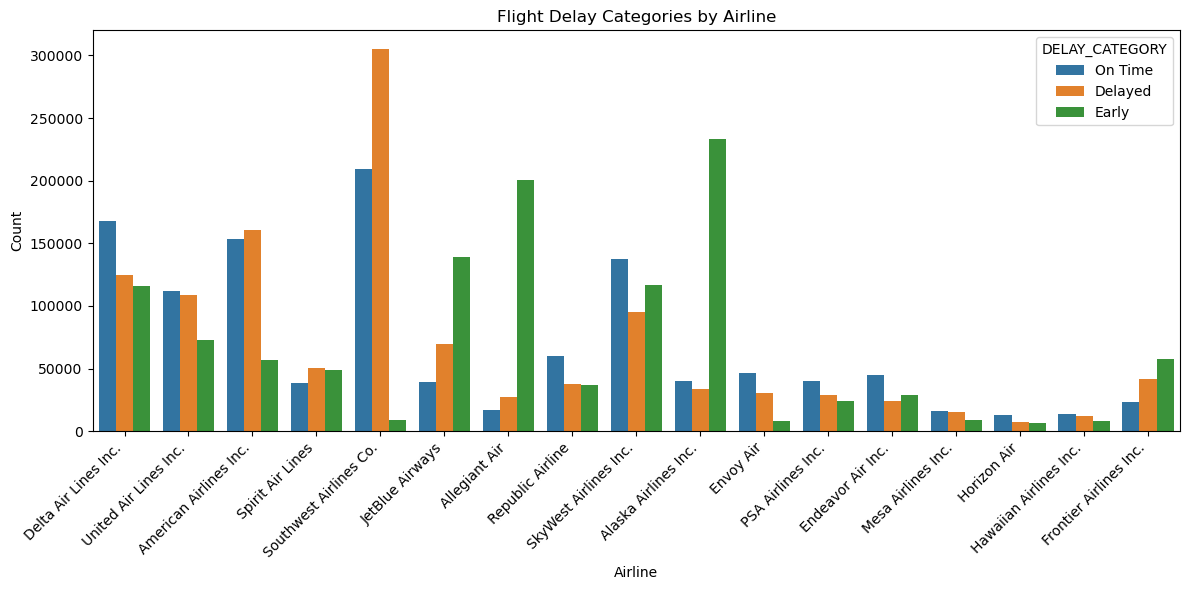

In [3]:
flight_data = model_helper.flight_dataset
# Create a bar plot showing delay categories by airline
plt.figure(figsize=(12, 6))
sns.countplot(data=flight_data, x='AIRLINE', hue='DELAY_CATEGORY')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Airline')
plt.ylabel('Count')
plt.title('Flight Delay Categories by Airline')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

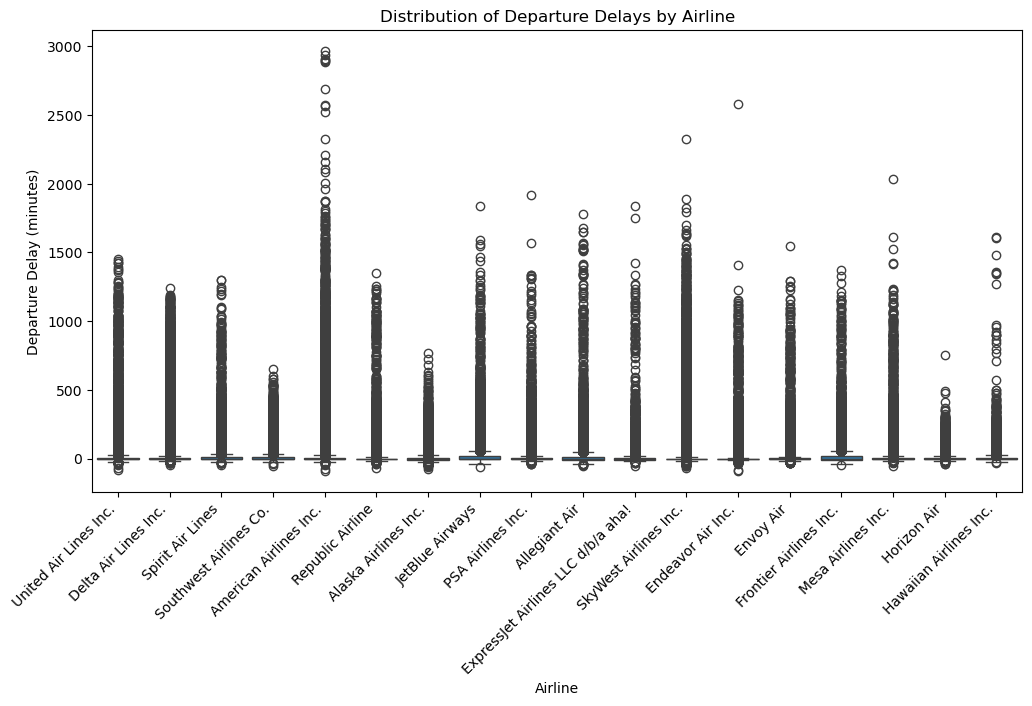

In [4]:
original_flight_data = model_helper.original_flight_dataset

# Create a box plot showing departure delay distribution by airline
plt.figure(figsize=(12, 6))

# Create boxplot using seaborn
sns.boxplot(data=original_flight_data, x='AIRLINE', y='DEP_DELAY')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Airline')
plt.ylabel('Departure Delay (minutes)')
plt.title('Distribution of Departure Delays by Airline')

# Show the plot
plt.show()

# Show the plot
plt.show()


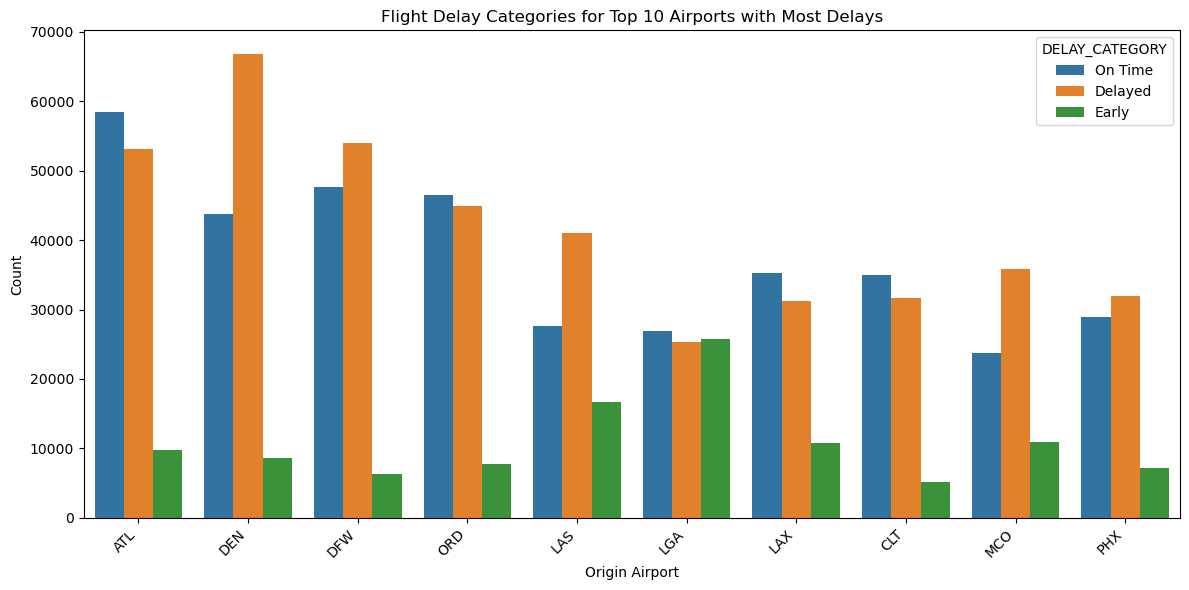

In [5]:
# Get the top 10 airports with most delays
delayed_flights = flight_data[flight_data['DELAY_CATEGORY'] != 'No Delay']
top_10_airports = delayed_flights['ORIGIN'].value_counts().nlargest(10).index

# Filter data for top 10 airports
plot_data = flight_data[flight_data['ORIGIN'].isin(top_10_airports)]

# Create a bar plot showing delay categories for top 10 airports
plt.figure(figsize=(12, 6))
sns.countplot(data=plot_data, x='ORIGIN', hue='DELAY_CATEGORY', order=top_10_airports)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Origin Airport')
plt.ylabel('Count')
plt.title('Flight Delay Categories for Top 10 Airports with Most Delays')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


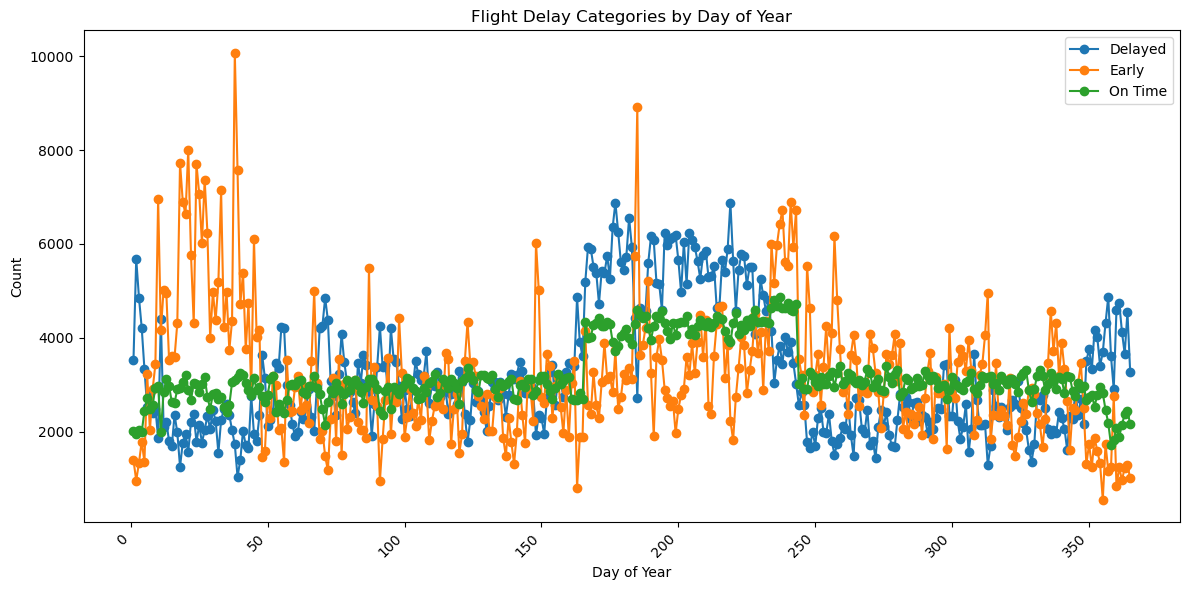

In [6]:
# Create a line plot showing delay categories by day of week
plt.figure(figsize=(12, 6))

# Group by day of week and delay category to get counts
delay_counts = flight_data.groupby(['DAY_OF_YEAR', 'DELAY_CATEGORY']).size().unstack()

# Plot lines for each delay category
for category in delay_counts.columns:
    plt.plot(delay_counts.index, delay_counts[category], marker='o', label=category)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.xlabel('Day of Year')
plt.ylabel('Count')
plt.title('Flight Delay Categories by Day of Year')
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

INFO:modelhelper:Starting flight delay model training process...
INFO:modelhelper:Flight dataset is already loaded. Using the loaded dataset...
INFO:modelhelper:Features being used: ['AIRLINE', 'ORIGIN', 'DAY_OF_YEAR', 'TOTAL_DELAY', 'MAX_DELAY', 'DELAY_VARIANCE', 'HISTORICAL_DELAY']
INFO:modelhelper:Step 3: Splitting data into train/test sets (test_size=0.2)...
INFO:modelhelper:Training set shape: (2812891, 7)
INFO:modelhelper:Test set shape: (703223, 7)
INFO:modelhelper:Step 4: Preprocessing features...
INFO:modelhelper:Step 5: Training logistic_regression model...
ERROR:modelhelper:Model file not found at models\logistic_regression_flight_delay_model.pkl
INFO:modelhelper:Training logistic_regression model for classification task
INFO:modelhelper:Features: ['AIRLINE', 'ORIGIN', 'DAY_OF_YEAR', 'TOTAL_DELAY', 'MAX_DELAY', 'DELAY_VARIANCE', 'HISTORICAL_DELAY']
INFO:modelhelper:Target: DELAY_CATEGORY
c:\Users\matth\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: Futur

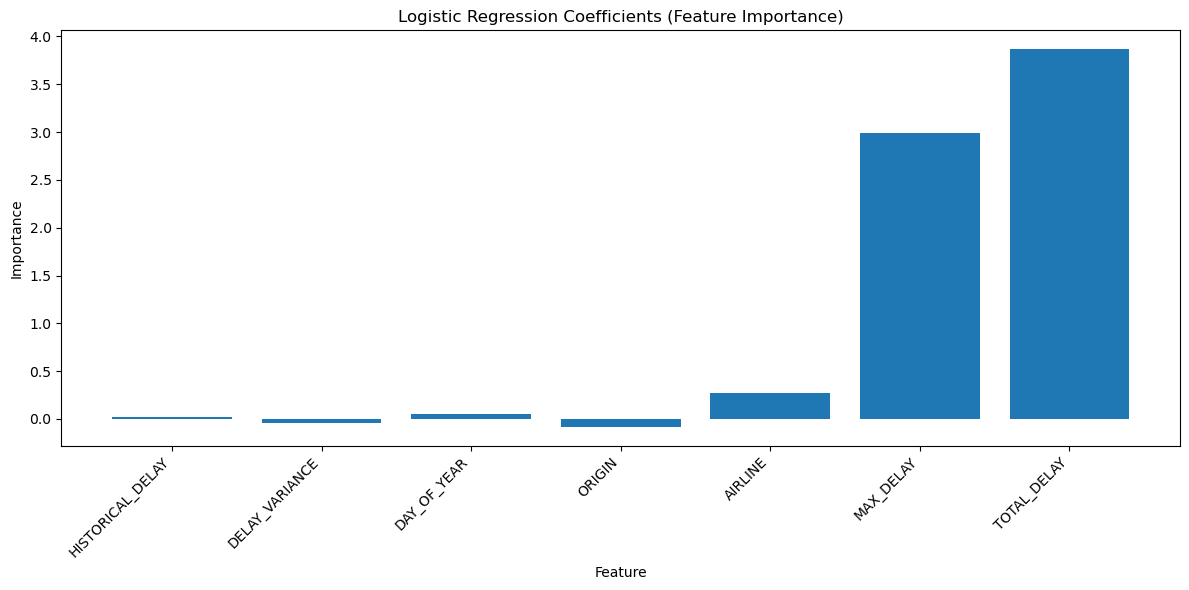

In [7]:
model, scores = model_helper.train_flight_delay_model("logistic_regression")

# For logistic regression, we can plot the coefficients to understand feature importance
# Get model coefficients and feature names
coefficients = model.coef_[0]  # Get coefficients for binary classification
feature_names = model_helper.xdata.columns

# Sort coefficients by absolute value
sorted_idx = np.argsort(np.abs(coefficients))
pos = np.arange(len(sorted_idx))

# Create coefficient plot
plt.figure(figsize=(12, 6))
plt.bar(pos, coefficients[sorted_idx])  # Changed from barh to bar
plt.xticks(pos, feature_names[sorted_idx], rotation=45, ha='right')  # Changed from yticks to xticks with rotation
plt.ylabel('Importance')  # Swapped x and y labels
plt.xlabel('Feature')
plt.title('Logistic Regression Coefficients (Feature Importance)')
plt.tight_layout()
plt.show()


INFO:modelhelper:Starting flight delay model training process...
INFO:modelhelper:Flight dataset is already loaded. Using the loaded dataset...
INFO:modelhelper:Features being used: ['AIRLINE', 'ORIGIN', 'DAY_OF_YEAR', 'TOTAL_DELAY', 'MAX_DELAY', 'DELAY_VARIANCE', 'HISTORICAL_DELAY']
INFO:modelhelper:Step 3: Splitting data into train/test sets (test_size=0.2)...
INFO:modelhelper:Training set shape: (2812891, 7)
INFO:modelhelper:Test set shape: (703223, 7)
INFO:modelhelper:Step 4: Preprocessing features...
INFO:modelhelper:Step 5: Training random_forest model...
INFO:modelhelper:Model successfully loaded from models\random_forest_flight_delay_model.pkl
INFO:modelhelper:Model random_forest already trained and loaded. Using the loaded model...
INFO:modelhelper:Step 6: Evaluating model performance...
INFO:modelhelper:
Model Evaluation Results:
INFO:modelhelper:Accuracy: 0.7662
INFO:modelhelper:Precision: 0.7839
INFO:modelhelper:Recall: 0.7662
INFO:modelhelper:F1: 0.7704
INFO:modelhelper:St

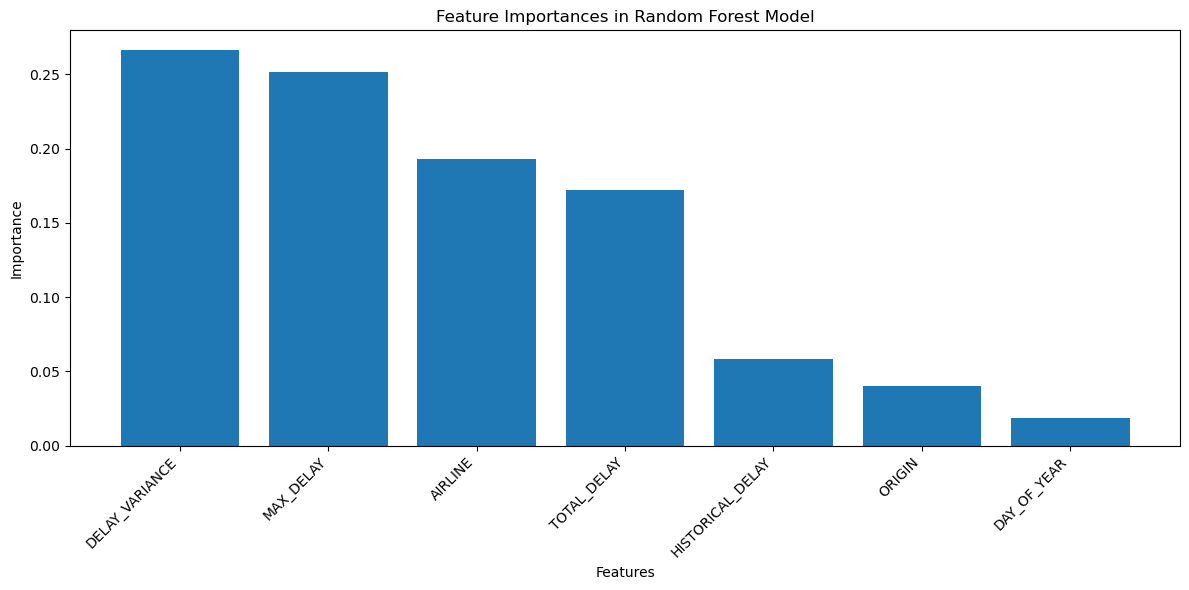

In [8]:
model, scores = model_helper.train_flight_delay_model('random_forest')

# Create feature importance plot for random forest model
importances = model.feature_importances_
feature_names = model_helper.xdata.columns

# Sort importances in descending order
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title('Feature Importances in Random Forest Model')
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()
